## Captum - Axiomatic Attribution for Deep Networks
https://arxiv.org/pdf/1703.01365

https://www.kaggle.com/rhtsingh/interpreting-text-models-with-bert-on-tpu

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import torch
import torch.nn as nn
from nlpClassifiers.data.dataset  import NLPDataset
from transformers import BertTokenizer, BertForSequenceClassification
from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients

/usr/local/lib/python3.6/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
model_base = 'bert-base-cased'
model_path ='../../models/agent-benchmark/bert-base-portuguese-tapt-classifier/base-dataset-agent-benchmark-agent-benchmark-100-epochs-early-stop-reset-3-bert-base-cased'
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# load model
model = BertForSequenceClassification.from_pretrained(model_path, output_attentions = False,
        output_hidden_states = False, num_labels=64)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_base)

In [4]:
device

device(type='cuda', index=2)

In [5]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [6]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


In [7]:
def predict(inputs, token_type_ids, attention_mask):
    return model(inputs, attention_mask, token_type_ids)[0]

def custom_forward(inputs, token_type_ids, attention_mask, label):
    preds = predict(inputs, token_type_ids, attention_mask)
    return torch.softmax(preds, dim = 1)[:, label]

def save_act(module, inp, out):
    return saved_act

hook = model.bert.embeddings.register_forward_hook(save_act)
hook.remove()

In [264]:
#Creates a list of tokens and attributions so we can plot the average attributions distribution for all tokens
def add_token_to_dict(token, attrib_score):
    if token != "[CLS]" and token != "[SEP]":
        try:
            if token not in attrib_tokens:
                attrib_tokens[token] = np.empty([0], dtype = float)
        except ValueError as error:
            print(error, token, attrib_tokens)
        attrib_tokens[token] = np.append(attrib_tokens[token], attrib_score)

In [209]:
def process(text, label):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
    
    attributions_main, delta_main = lig.attribute(inputs=input_ids,
                                                  baselines=ref_input_ids,
                                                  n_steps = 150,
                                                  additional_forward_args=(token_type_ids, attention_mask, label),
                                                  return_convergence_delta=True)
    
    score = predict(input_ids, token_type_ids, attention_mask)
    attributions_main = attributions_main.cpu()
    delta_main = delta_main.cpu()
    score = score.cpu()
    prd_label = torch.argmax(torch.softmax(score, dim = 1)[0])
    
    #inv_label = 101
    #if(prd_label == inv_label or label == inv_label):
    r_df = add_attributions_to_visualizer(attributions_main, delta_main, text, score, label, all_tokens)
    return r_df
    
def add_attributions_to_visualizer(attributions, delta, text, score, label, all_tokens):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu()
    pred_class = torch.argmax(torch.softmax(score, dim = 1)[0])
    pred_score = torch.softmax(score, dim = 1)[0][pred_class]
    
    if(label == pred_class):
        l = 'Correct'
    else:
        l = 'Incorrect'
        
    ix = 0

    for token in all_tokens:
        add_token_to_dict(token,attributions[ix])
        ix+=1
    
    df = pd.DataFrame({"result":l, "score":pred_score.item(), "attribution_score":attributions.sum().item()}, index=[0])
    score_vis.append(
        viz.VisualizationDataRecord(
            attributions,
            pred_score,
            pred_class,
            label,
            label,
            attributions.sum(),
            all_tokens,
            delta
        )
    )
    return df,attributions,all_tokens

In [210]:
def read_data(filename):
    data = pd.read_csv(filename, sep=";", names =['utterance','label'], header=None, dtype={'utterance':str, 'label': str} )
    return data

In [211]:
DATA_PATH = '../../data/agent-benchmark'
TRAIN_DATASET  = os.path.join(DATA_PATH, 'train.csv')
TEST_DATASET  = os.path.join(DATA_PATH, 'test.csv')

In [90]:
test_dataset = read_data(TEST_DATASET).dropna()

In [91]:
train_corpus = NLPDataset('agent-benchmark', "train", 82, model_base)
test_corpus = NLPDataset('agent-benchmark', "test", 82, model_base)
labels_dict = train_corpus.labels_dict

In [81]:
train_dataset = read_data(TRAIN_DATASET).dropna()

In [82]:
pd.set_option('display.max_rows', None)
train_dataset[train_dataset['label']=='calendar_notification']

,utterance,label
0,where is my meeting today located,calendar_notification
197,upcoming meeting,calendar_notification
531,click save,calendar_notification
602,please set a notification on twenty third octo...,calendar_notification
753,remind me of mondays meeting,calendar_notification
761,remind me of my meeting on wednesday at nine am,calendar_notification
1002,tell me when the event is happening,calendar_notification
1102,set a notification about my meeting next tuesday,calendar_notification
1179,send me an alert and hour before my next appoi...,calendar_notification
1283,remind me when the concert tickets go on sale,calendar_notification


## Analysis over 3 classes:
    115 - Sintomas.Genérico.Promessa de oferta
    108 - Sintomas.Qualificado.Cliente está longe
    116 - Sintomas.Qualificado.Ausência sinal geral


In [265]:
score_vis = []
attrib_tokens = {}
results_df = pd.DataFrame() 
for step,row in tqdm_notebook(test_corpus.df.iterrows(), total=test_corpus.df.shape[0]):
 #   if step == 500:
 #       break
    text = row['utterance']
    label = train_corpus.labels_dict.get(row['label'])
    if label == 38:
     #if label == 15:
        df,attributions,all_tokens = process(text, label)
        results_df = results_df.append(df, ignore_index=True)

In [273]:
tokens_list = []
attrib_list =np.empty([len(attrib_tokens)], dtype = float)
i = 0
for k in attrib_tokens:
    # v is the list of grades for student k
    tokens_list.append(k)
    attrib_list[i]=sum(attrib_tokens[k])/ float(len(attrib_tokens[k]))
    i+=1
    
    
n = 20  #how many highest and lowest importances we want to plot
sorted_imp_idx = attrib_list.argsort()
lowest_imp_idx = sorted_imp_idx[:n]
highest_imp_idx = sorted_imp_idx[-n:]
imp_idx = np.concatenate((lowest_imp_idx, highest_imp_idx), axis=None)
attrib_list = attrib_list[imp_idx]
tokens_list = np.array(tokens_list)[imp_idx.astype(int)]

In [274]:
def getcolor(result):
    if result:
        return 'g'
    else:
        return 'r'

Text(0.5, 1.0, 'Average Feature Importances')

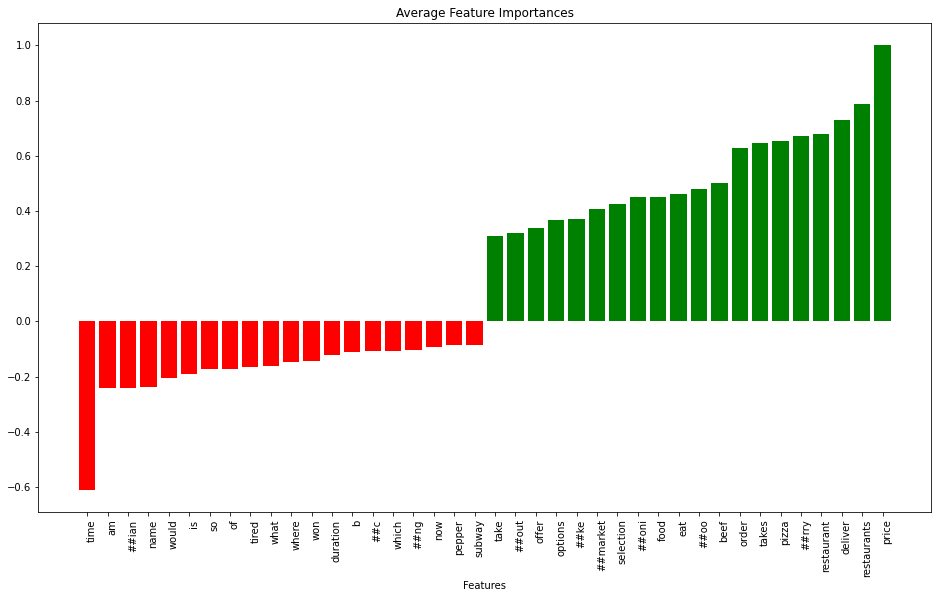

In [275]:
title="Average Feature Importances"
axis_title="Features"
x_pos = (np.arange(len(tokens_list)))
plt.figure(figsize=(16,9))
plt.bar(x_pos, attrib_list, align='center',color=list(map(getcolor, (attrib_list > 0.))))
plt.xticks(x_pos, list(tokens_list), wrap=True,rotation='vertical',ha='right')
#plt.margins(0.1)
#plt.subplots_adjust(bottom=0.15)
plt.xlabel(axis_title)
plt.title(title)

In [114]:
import matplotlib.pyplot as plt

In [126]:
attributions

tensor([ 0.0000, -0.0183,  0.9417, -0.0954,  0.3167,  0.0286,  0.0508,  0.0000],
       dtype=torch.float64)

In [39]:
results_df[results_df['result']=='Correct']['attribution_score'].mean()

1.6158006012404162

In [40]:
results_df[results_df['result']=='Incorrect']['attribution_score'].mean()

0.53057375797617

Text(0.5, 0.98, 'Sintomas.Genérico.Promessa de oferta')

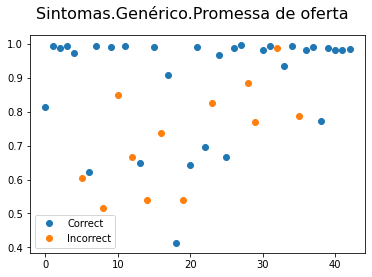

In [41]:
groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Genérico.Promessa de oferta', fontsize=16)

Text(0.5, 0.98, 'Sintomas.Genérico.Promessa de oferta')

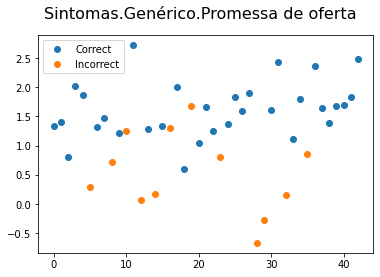

In [42]:
groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["attribution_score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Genérico.Promessa de oferta', fontsize=16)

In [43]:
x = viz.visualize_text(score_vis)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
18,18 (0.81),18,1.33,[CLS] where can i go shopping here [SEP]
18,18 (0.99),18,1.41,[CLS] hey sir ##i give me a list of nearby shops [SEP]
18,18 (0.99),18,0.81,[CLS] tea ##a shop [SEP]
18,18 (0.99),18,2.02,[CLS] can you find a nice restaurant downtown [SEP]
18,18 (0.97),18,1.86,[CLS] what chin ##ese restaurants are in my area [SEP]
18,14 (0.60),18,0.29,[CLS] tell me where the local shopping district is [SEP]
18,18 (0.62),18,1.32,[CLS] find g ##lut ##en free bakery near me [SEP]
18,18 (0.99),18,1.47,[CLS] what shops are around me [SEP]
18,17 (0.52),18,0.72,[CLS] what me ##xi ##can food is around me [SEP]
18,18 (0.99),18,1.22,[CLS] what pubs are close to me [SEP]


In [61]:
score_vis = []
results_df = pd.DataFrame() 
for step,row in tqdm_notebook(test_corpus.df.iterrows(), total=test_corpus.df.shape[0]):
#    if step == 50:
#        break
    text = row['utterance']
    label = train_corpus.labels_dict.get(row['label'])
    if label == 18:
        df = process(text, label)
        results_df = results_df.append(df, ignore_index=True)

Text(0.5, 0.98, 'Sintomas.Qualificado.Cliente está longe')

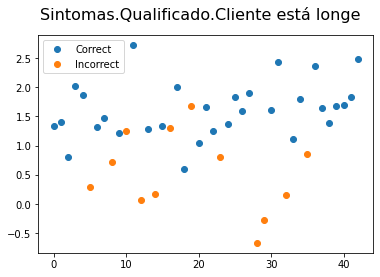

In [36]:
groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["attribution_score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Qualificado.Cliente está longe', fontsize=16)

In [37]:
viz.visualize_text(score_vis)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
18,18 (0.81),where can i go shopping here,1.33,[CLS] where can i go shopping here [SEP]
18,18 (0.99),hey siri give me a list of nearby shops,1.41,[CLS] hey sir ##i give me a list of nearby shops [SEP]
18,18 (0.99),teaa shop,0.81,[CLS] tea ##a shop [SEP]
18,18 (0.99),can you find a nice restaurant downtown,2.02,[CLS] can you find a nice restaurant downtown [SEP]
18,18 (0.97),what chinese restaurants are in my area,1.86,[CLS] what chin ##ese restaurants are in my area [SEP]
18,14 (0.60),tell me where the local shopping district is,0.29,[CLS] tell me where the local shopping district is [SEP]
18,18 (0.62),find gluten free bakery near me,1.32,[CLS] find g ##lut ##en free bakery near me [SEP]
18,18 (0.99),what shops are around me,1.47,[CLS] what shops are around me [SEP]
18,17 (0.52),what mexican food is around me,0.72,[CLS] what me ##xi ##can food is around me [SEP]
18,18 (0.99),what pubs are close to me,1.22,[CLS] what pubs are close to me [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
18,18 (0.81),where can i go shopping here,1.33,[CLS] where can i go shopping here [SEP]
18,18 (0.99),hey siri give me a list of nearby shops,1.41,[CLS] hey sir ##i give me a list of nearby shops [SEP]
18,18 (0.99),teaa shop,0.81,[CLS] tea ##a shop [SEP]
18,18 (0.99),can you find a nice restaurant downtown,2.02,[CLS] can you find a nice restaurant downtown [SEP]
18,18 (0.97),what chinese restaurants are in my area,1.86,[CLS] what chin ##ese restaurants are in my area [SEP]
18,14 (0.60),tell me where the local shopping district is,0.29,[CLS] tell me where the local shopping district is [SEP]
18,18 (0.62),find gluten free bakery near me,1.32,[CLS] find g ##lut ##en free bakery near me [SEP]
18,18 (0.99),what shops are around me,1.47,[CLS] what shops are around me [SEP]
18,17 (0.52),what mexican food is around me,0.72,[CLS] what me ##xi ##can food is around me [SEP]
18,18 (0.99),what pubs are close to me,1.22,[CLS] what pubs are close to me [SEP]


In [19]:
score_vis = []
results_df = pd.DataFrame() 
for step,row in tqdm_notebook(test_corpus.df.iterrows(), total=test_corpus.df.shape[0]):
#    if step == 50:
#        break
    text = row['utterance']
    label = train_corpus.labels_dict.get(row['label'])
    if label == 116:
        df = process(text, label)
        results_df = results_df.append(df, ignore_index=True)

Text(0.5, 0.98, 'Sintomas.Qualificado.Ausência sinal geral')

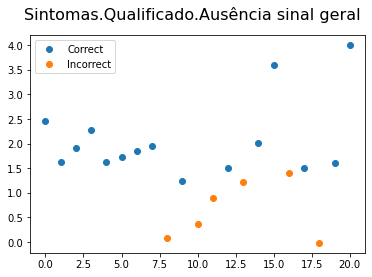

In [20]:
groups = results_df.groupby("result")
for name, group in groups:
    plt.plot(group["attribution_score"],  marker="o", linestyle="", label=name)
plt.legend()
plt.suptitle('Sintomas.Qualificado.Ausência sinal geral', fontsize=16)

In [21]:
viz.visualize_text(score_vis)

In [22]:
Sintomas.Genérico.Promessa de oferta
Sintomas.Qualificado.Cliente está longe
Sintomas.Qualificado.Ausência sinal geral


SyntaxError: invalid syntax (<ipython-input-22-eb244cb87906>, line 1)

In [ ]:
print(list(labels_dict.keys())[list(labels_dict.values()).index(116)])

In [ ]:
print(labels_dict.get('Sintomas.Qualificado.Recarga'))